<a href="https://colab.research.google.com/github/zhiyi-set/Compute-Risk-Lower-Bounds/blob/main/ISIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64


# Example 1
Compare
\begin{align*}
&R^{\rm chen}_f =\left\{\begin{matrix}
0 ,&1-u_f(J_f(W,\widehat{W}))\leq \frac{1}{k}  \\
 \frac{1}{2},&   \text{otherwise}\\
\end{matrix}\right.\\
&R^{\rm int}_f=R_f^{\rm mrk}=R_f^{0/1}=1-\eta_f\left(I_f(W;\widehat{W})\Vert 1/k\right)
\end{align*}

In [3]:
# f functions
def make_f(kind: str):
  kind = kind.lower()
  if kind == "kl":
    # f(t)= t log t
    def f(t):
      t = torch.clamp(t, min=1e-30)
      return t * torch.log(t)
    return f
  if kind == "tv":
    # f(t)= 1/2 |t-1|
    def f(t):
      return 0.5 * torch.abs(t - 1.0)
    return f
  if kind == "chi2":
    # f(t)= (t-1)^2
    def f(t):
      return (t - 1.0) ** 2
    return f
  if kind == "h2":
    # f(t)= 1/2 (sqrt(t)-1)^2
    def f(t):
      t = torch.clamp(t, min=0.0)
      return 0.5 * (torch.sqrt(t) - 1.0) ** 2
    return f
  raise ValueError("kind must be one of: kl, tv, chi2, h2")

# I_f(W;What)= (1/k) f(k(1-eps)) + ((k-1)/k) f(k eps/(k-1))
def I_f_kary(k: int, eps: torch.Tensor, kind: str) -> torch.Tensor:
  f = make_f(kind)
  k_t = torch.tensor(float(k), dtype=eps.dtype, device=eps.device)
  td = k_t * (1.0 - eps)                     # k(1-eps)
  to = k_t * eps / (k_t - 1.0)               # k eps/(k-1)
  return (1.0 / k_t) * f(td) + ((k_t - 1.0) / k_t) * f(to)

# phi_f(p,q)= q f(p/q) + (1-q) f((1-p)/(1-q))
def phi_f_bern(p: torch.Tensor, q: torch.Tensor, kind: str) -> torch.Tensor:
  f = make_f(kind)
  eps = torch.tensor(1e-30, dtype=p.dtype, device=p.device)
  p = torch.clamp(p, 0.0, 1.0)
  q = torch.clamp(q, 0.0, 1.0)
  q_safe = torch.clamp(q, eps, 1.0 - eps)
  return q_safe * f(p / q_safe) + (1.0 - q_safe) * f((1.0 - p) / (1.0 - q_safe))

# u_f(C) = inf{ q in [1/2,1] : phi_f(1/2,q) > C }
def u_f_closed(C: torch.Tensor, kind: str) -> torch.Tensor:
  kind = kind.lower()
  # C is scalar tensor
  C0 = torch.clamp(C, min=0.0)

  if kind == "tv":
    # phi(1/2,q) = |q-1/2|
    return torch.clamp(0.5 + C0, max=torch.tensor(1.0, dtype=C.dtype, device=C.device))

  if kind == "kl":
    # phi(1/2,q) = -0.5 log(4 q(1-q))
    # solve for smallest q>=1/2 s.t. phi > C:
    # q = (1 + sqrt(1 - exp(-2C)))/2
    x = 1.0 - torch.exp(-2.0 * C0)
    x = torch.clamp(x, 0.0, 1.0)
    return 0.5 * (1.0 + torch.sqrt(x))

  if kind == "chi2":
    # phi(1/2,q) = (q-1/2)^2 / (q(1-q))
    # q = 0.5(1 + sqrt(C/(1+C)))
    return 0.5 * (1.0 + torch.sqrt(C0 / (1.0 + C0)))

  if kind == "h2":
    # phi(1/2,q) = 1 - (sqrt(q)+sqrt(1-q))/sqrt(2)
    # max on [1/2,1] is 1-1/sqrt(2). if C >= max -> set empty -> u=1
    phi_max = 1.0 - 1.0 / math.sqrt(2.0)
    if float(C0) >= phi_max:
      return torch.tensor(1.0, dtype=C.dtype, device=C.device)
    s = (2.0 * (1.0 - C0) ** 2 - 1.0) / 2.0
    inside = 1.0 - 4.0 * (s ** 2)
    inside = torch.clamp(inside, min=0.0)
    return 0.5 * (1.0 + torch.sqrt(inside))

  raise ValueError("kind must be one of: kl, tv, chi2, h2")

# eta_f(C||q): sup{ p in [0,1] : phi_f(p,q) <= C }
def eta_f(C: torch.Tensor, q: torch.Tensor, kind: str, tol=1e-12, max_iter=200) -> torch.Tensor:
  kind = kind.lower()
  C0 = torch.clamp(C, min=0.0)

  # trivial q==1: phi(p,1) minimized at p=1 gives 0 -> eta=1
  if float(q) >= 1.0 - 1e-15:
    return torch.tensor(1.0, dtype=C.dtype, device=C.device)

  if kind == "tv":
    # phi = |p-q|
    return torch.clamp(q + C0, max=torch.tensor(1.0, dtype=C.dtype, device=C.device))

  if kind == "chi2":
    # phi = (p-q)^2 / (q(1-q))
    return torch.clamp(q + torch.sqrt(C0 * q * (1.0 - q)),
                          max=torch.tensor(1.0, dtype=C.dtype, device=C.device))
  if kind == "h2":
    C = C0  # use the same C as in the other branches

    one = torch.tensor(1.0, dtype=q.dtype, device=q.device)
    zero = torch.tensor(0.0, dtype=q.dtype, device=q.device)

    cond = q <= (one - C).pow(2)

    term1 = torch.sqrt(torch.clamp(q, min=zero)) * (one - C)
    term2_inside = torch.clamp((one - q) * (2.0 - C) * C, min=zero)
    term2 = torch.sqrt(term2_inside)

    eta = (term1 + term2).pow(2)

    # piecewise: eta if cond else 1, and clamp for numerical safety
    return torch.where(cond, torch.clamp(eta, max=one), one)


  # bisection for KL
  lo = q.clone()
  hi = torch.tensor(1.0, dtype=C.dtype, device=C.device)

  # if p=1 is feasible, eta=1
  if float(phi_f_bern(hi, q, kind)) <= float(C0):
    return hi

  for _ in range(max_iter):
    mid = (lo + hi) / 2.0
    val = phi_f_bern(mid, q, kind)
    if float(val) <= float(C0):
      lo = mid
    else:
      hi = mid
    if float(hi - lo) <= tol:
      break
  return lo


# R_chen and R_ours
def R_chen_single(k: int, I_or_J: torch.Tensor, kind: str) -> torch.Tensor:
  # J_f = I_f, so input is I_f (scalar tensor)
  u = u_f_closed(I_or_J, kind)
  theta = 1.0 - u  # need Q(t) < theta
  # Q(t)=1/k for t in (0,1], so sup t is 1 if 1/k < theta else 0
  return 0.5 * torch.where(torch.tensor(1.0 / k, dtype=I_or_J.dtype, device=I_or_J.device) < theta,
                torch.tensor(1.0, dtype=I_or_J.dtype, device=I_or_J.device),
                torch.tensor(0.0, dtype=I_or_J.dtype, device=I_or_J.device))

def R_our_single(k: int, I: torch.Tensor, kind: str) -> torch.Tensor:
  # R_our = 1 - eta_f(I || 1/k)
  q0 = torch.tensor(1.0 / k, dtype=I.dtype, device=I.device)
  eta0 = eta_f(I, q0, kind)
  return 1.0 - eta0

# Plot R_chen and R_ours vs epsilon
def plot_Rs_vs_epsilon(k=10, divergence="kl", n_points=400, device="cpu"):
  dtype = torch.float64
  eps_grid = torch.linspace(0.0, 1.0, n_points, dtype=dtype, device=device)

  I_vals = I_f_kary(k, eps_grid, divergence)  # vector
  Rchen = torch.empty_like(eps_grid)
  Rour  = torch.empty_like(eps_grid)

  # vectorize by looping over eps (u_f and eta_f use scalar logic)
  for i in range(n_points):
    I = I_vals[i]
    Rchen[i] = R_chen_single(k, I, divergence)
    Rour[i]  = R_our_single(k, I, divergence)

  # plot
  plt.figure(figsize=(4, 3))
  # plt.plot(eps_grid.cpu().numpy(), eps_grid.cpu().numpy(), label=r"${R(\mu)}$")
  plt.plot(eps_grid.cpu().numpy(), Rchen.cpu().numpy(), label=r"$\mathsf{R}_f^{\rm chen}$")
  plt.plot(eps_grid.cpu().numpy(), Rour.cpu().numpy(),  label=r"$\mathsf{R}_f^{\rm int},\mathsf{R}_f^{\rm mkv},\mathsf{R}_f^{0/1}$")
  plt.xlabel(r"$\epsilon$")
  plt.ylabel(r"$\mathsf{R}$")
  plt.grid(True, alpha=0.3)
  plt.legend()
  # # save the plot as vector graph
  # plt.tight_layout()
  # plt.savefig("eg1-tv.pdf", format="pdf", bbox_inches="tight")
  plt.show()


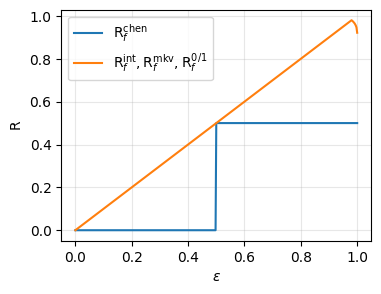

In [5]:
k = 50
divergence = "h2"   # choose: "kl", "tv", "chi2", "h2"
plot_Rs_vs_epsilon(k=k, divergence=divergence, n_points=401)

# Example 2
Compare
\begin{align*}
    R_f^{\rm chen}&=\frac{1}{2} \left(\Phi^{-1}\left(1-\frac{u_f(J_f(W;\widehat{W}))}{2}\right)\right)^2\\
     R_f^{\rm int}&=\int_{\mathbb{R}^+} 1- \eta_f\big(I_f(W;\widehat{W})\Vert 2\Phi(\sqrt{t})-1\big) \; dt\\
     R_f^{\rm mrk}&=\sup_{t>1} t\left(1- \eta_f\big(I_f(W;\widehat{W})\Vert 2\Phi(\sqrt{t})-1\big) \right)
\end{align*}

In [ ]:
# CDF of standard normal
def Phi(x: torch.Tensor) -> torch.Tensor:
  return 0.5 * (1.0 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))
# Inverse Phi
def norm_ppf(p: torch.Tensor) -> torch.Tensor:
  return torch.sqrt(torch.tensor(2.0)) * torch.erfinv(2.0*p - 1.0)

# small ball prob
def Q_mu_W(t):
  return 2*Phi(torch.sqrt(t)) - 1

# u_f of four divergences
def u_KL(C):
  return 0.5 * (1.0 + torch.sqrt(1.0 - torch.exp(-2.0*C)))

def u_TV(C):
  return torch.minimum(torch.ones_like(C), C + 0.5)

def u_chi2(C):
  return 0.5 * (1.0 + torch.sqrt(C / (1.0 + C)))

def u_H2(C):
  C = torch.as_tensor(C)
  Cmax = 1.0 - 1.0 / torch.sqrt(torch.tensor(2.0, device=C.device, dtype=C.dtype))
  one = torch.ones_like(C)
  mask = C >= Cmax
  out = torch.empty_like(C)
  out[mask] = 1.0
  Cm = C[~mask]
  if Cm.numel() > 0:
      B = torch.sqrt(torch.tensor(2.0, device=C.device, dtype=C.dtype)) * (1.0 - Cm)
      D = 1.0 - (B*B - 1.0)**2
      D = torch.clamp(D, min=0.0)
      out[~mask] = 0.5 * (1.0 + torch.sqrt(D))
  return out

# eta_f of four divergences: formulas in section 4
def eta_KL(C, q):
  # eta_KL = (C + log(2-q)) / (-log q)
  eps = 1e-15
  q = torch.clamp(q, eps, 1.0 - eps)
  out = (C + torch.log(2.0 - q)) / (-torch.log(q))
  return torch.clamp(out, 0.0, 1.0)

def eta_TV(C, q):
  return torch.minimum(torch.ones_like(q + C), C + q)

def eta_chi2(C, q):
  return torch.minimum(torch.ones_like(q + C), torch.sqrt(q*(1.0-q)*C) + q)

def eta_H2(C, q):
  thresh = (1.0 - C)**2
  expr = (torch.sqrt(q)*(1.0 - C) + torch.sqrt((1.0 - q)*(2.0 - C)*C))**2
  out = torch.where(q <= thresh, expr, torch.ones_like(expr))
  return torch.clamp(out, 0.0, 1.0)

# I_f and J_f
def I_KL(rho):
  return -0.5 * torch.log((1.0 - rho)**2)

def J_KL(rho):
  return I_KL(rho)

def I_chi2(rho):
  return rho*rho / (1.0 - rho*rho)

def J_chi2(rho):
  return torch.sqrt((1.0 + rho*rho) / (1.0 - rho*rho)) - 1.0

def I_H2(rho):
  det_S = 1.0 - rho*rho
  det_avg = 1.0 - (rho*rho)/4.0
  BC = det_S.pow(0.25) / torch.sqrt(det_avg)
  return 1.0 - BC

def J_H2(rho):
  num = 2.0 * (1.0 - rho*rho)
  den = 2.0 - rho*rho
  BC_star = (num / den).pow(0.25)
  return 1.0 - BC_star


# TV via Gauss–Hermite quadrature
def hermgauss_torch(n, device, dtype):
  xs, ws = np.polynomial.hermite.hermgauss(n)
  xs_t = torch.tensor(xs, device=device, dtype=dtype)
  ws_t = torch.tensor(ws, device=device, dtype=dtype)
  return xs_t, ws_t

def prob_Astar_indep_normals(r_abs, sigU, sigV, xs, ws):
  # constants
  a = r_abs * (1.0 - r_abs)
  b = r_abs * (1.0 + r_abs)
  K = (1.0 - r_abs*r_abs) * torch.log(1.0 / (1.0 - r_abs*r_abs))
  v0 = torch.sqrt(K / b)

  # GH for X~N(0,1): E[f(X)] = 1/sqrt(pi) * Σ w_i f(sqrt(2) x_i)
  v = sigV * torch.sqrt(torch.tensor(2.0, device=xs.device, dtype=xs.dtype)) * xs
  av = torch.abs(v)

  g = torch.ones_like(av)
  mask = av > v0
  if mask.any():
    # u0 = torch.sqrt((b*av[mask]*av[mask] - K) / a)
    tmp = (b*av[mask]*av[mask] - K) / a
    tmp = torch.clamp(tmp, min=0.0)
    u0 = torch.sqrt(tmp)

    g[mask] = 2.0 * (1.0 - Phi(u0 / sigU))

  return (ws * g).sum() / torch.sqrt(torch.tensor(np.pi, device=xs.device, dtype=xs.dtype))

def I_TV(rho, gh_n=260):
  """
  I_TV(W;W_hat) = TV(N(0,Sigma_rho), N(0,I)).
  Computed as P_mu(A*) - P_0(A*), using 1D GH quadrature.
  """
  device, dtype = rho.device, rho.dtype
  xs, ws = hermgauss_torch(gh_n, device=device, dtype=dtype)

  r = torch.abs(rho)
  if r.item() == 0.0:
    return torch.zeros_like(r)

  P_mu = prob_Astar_indep_normals(
      r_abs=r,
      sigU=torch.sqrt(1.0 + r),
      sigV=torch.sqrt(1.0 - r),
      xs=xs, ws=ws
  )
  P_0 = prob_Astar_indep_normals(
      r_abs=r,
      sigU=torch.tensor(1.0, device=device, dtype=dtype),
      sigV=torch.tensor(1.0, device=device, dtype=dtype),
      xs=xs, ws=ws
  )
  return P_mu - P_0

def I_TV_vec(rhos, gh_n=260):
  # simple loop; for 100-500 grid points
  out = []
  for r in rhos:
      out.append(I_TV(r, gh_n=gh_n))
  return torch.stack(out, dim=0)

def J_TV_vec(rhos, gh_n=260):
  # you didn't provide J_TV; we use J_TV ≈ I_TV
  return I_TV_vec(rhos, gh_n=gh_n)

# evaluate the term 1-eta_f(I_f || Q(c))
def One_minus_eta(t: torch.Tensor, rho: torch.Tensor, div: str) -> torch.Tensor:
  if t.dim() != 1:
        t = t.reshape(-1)
  rho = rho.reshape(-1)  # scalar -> [1]
  Qt = Q_mu_W(t).to(dtype=t.dtype, device=t.device)          # [N]
  Qt = torch.clamp(Qt, 1e-12, 1.0 - 1e-12)                   # avoid log(0), sqrt issues
  Qt = Qt.unsqueeze(0)
  if div == "kl":
    #  1 - (I + log(2 - Q(t))) / (-logQ(t))
    I_f = I_KL(rho).unsqueeze(1)  # [M,1]
    # Qt = Q_mu_W(t)
    # t = torch.clamp(t, min=1e-12)

    return 1.0-(I_f+torch.log(2-Qt))/(-torch.log(Qt))
  if div == "chi2":
    I_f = I_chi2(rho)
    # Qt = Q_mu_W(t)
    print(Qt)
    return 1-torch.sqrt(I_f * Qt * (1-Qt)) - Qt
  if div == 'h2':
    I_f = I_H2(rho)
    # Qt = Q_mu_W(t)

    cond = Qt > (1 - I_f) ** 2
    val_else = 1 - (torch.sqrt(Qt) * (1 - I_f)
              + torch.sqrt((1 - Qt) * (2 - Qt) * I_f))**2

    return torch.where(cond, torch.ones_like(Qt), val_else)
  if div == 'tv':
    I_f = I_TV(rho)
    # Qt = Q_mu_W(t)
    return 1-torch.minimum(Qt + I_f, torch.ones_like(Qt))

# R_chen and R_ours
def R_chen(J, u_func):
  u = u_func(J)
  p = 1.0 - u/2.0
  p = torch.clamp(p, 1e-12, 1.0 - 1e-12)
  z = norm_ppf(p)
  return 0.5 * z*z

def R_int(I, eta_func, t_max=8.0, n_t=8001):
  device, dtype = I.device, I.dtype
  x = torch.linspace(0.0, t_max, n_t, device=device, dtype=dtype)
  q = 2.0*Phi(x) - 1.0
  w = 2.0*x  # dt weight

  # Broadcast: I[:,None] with q[None,:]
  eta = eta_func(I[:, None], q[None, :])
  integrand = (1.0 - eta) * w[None, :]
  # trapz along x
  return torch.trapz(integrand, x, dim=1)


def R_mkv(rho, div, t_max=8.0, n_t=8001):
  t_grid = torch.linspace(0.0, t_max, steps=n_t)  # [N]

  one_minus = One_minus_eta(t_grid, rho, div)          # [M, N]
  risks = t_grid.unsqueeze(0) * one_minus              # [M, N]
  risk_max, _ = risks.max(dim=1)
  return risk_max



# compute curves
# div \in { "kl", "tv", "chi2", "h2" }
def compute_curves(div="kl", rho_max=0.99, n_rho=101, gh_n=260, x_max=8.0, n_x=8001):
  rhos = torch.linspace(0.0, rho_max, n_rho, device=device, dtype=dtype)
  if div == "kl":
    I_f = I_KL(rhos)
    J_f = J_KL(rhos)
    Rchen = R_chen(J_f, u_KL)
    Rint = R_int(I_f, eta_KL, x_max, n_x)
  if div == "chi2":
    I_f = I_chi2(rhos)
    J_f = J_chi2(rhos)
    Rchen = R_chen(J_f, u_chi2)
    Rint = R_int(I_f, eta_chi2, x_max, n_x)
  if div == "h2":
    I_f = I_H2(rhos)
    J_f = J_H2(rhos)
    Rchen = R_chen(J_f, u_H2)
    Rint = R_int(I_f, eta_H2, x_max, n_x)
  if div == "tv":
    I_f = I_TV_vec(rhos, gh_n=gh_n)
    J_f = J_TV_vec(rhos, gh_n=gh_n)
    Rchen = R_chen(J_f, u_TV)
    Rint = R_int(I_f, eta_TV, x_max, n_x)


  Rmrk = R_mkv(rhos, 'kl', t_max=1.0, n_t=2001)

  return {
      "rhos": rhos,
      "risks": (Rchen, Rint, Rmrk)
  }


In [ ]:
def plot_curves(out, div="kl"):
  """
  Plot R_chen and R_ours vs rho.

  Parameters
  ----------
  out : dict
      Output of compute_curves(...), containing:
      out["rhos"], out["kl"], out["tv"], out["chi2"], out["h2"].
  div : str
      Which divergence to plot, in {"kl", "tv", "chi2", "h2"}
  """
  rhos = out["rhos"].detach().cpu().numpy()
  div_norm = str(div).strip().lower()


  Rchen, Rint, Rmkv = out["risks"]
  y_0 = 2*(1-rhos)
  y1 = Rchen.detach().cpu().numpy()
  y2 = Rint.detach().cpu().numpy()
  y3 = Rmkv.detach().cpu().numpy()

  plt.figure(figsize=(4, 3))
  # plt.plot(rhos, y_0, label=r"$R(\mu)$") #real value of R(\mu)
  plt.plot(rhos, y1, label=r"$\mathsf{R}_f^{\rm chen}$")
  plt.plot(rhos, y2, label=r"$\mathsf{R}_f^{\rm int}$")
  plt.plot(rhos, y3, label=r"$\mathsf{R}_f^{\rm mkv}$")
  plt.xlabel(r"$\rho$")
  plt.ylabel(r"$R$")
  plt.grid(True, alpha=0.3)
  plt.legend()
  # # save plot as a vector graph
  plt.tight_layout()
  plt.savefig("eg2-h2.pdf", format="pdf", bbox_inches="tight")
  plt.show()


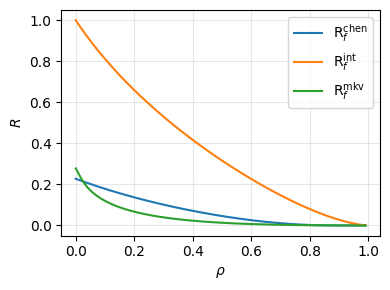

In [ ]:
# choose div in { "kl", "tv", "chi2", "h2" }
div = "h2"
# out is a dict
out = compute_curves(div,
    rho_max=0.99, n_rho=200,
    gh_n=370, x_max=8.0, n_x=20000)

plot_curves(out, div)

